© 2023 Yun Na Lee imyun0315@gmail.com

코드 사용 시, 출처 표기 바랍니다.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  

### 1. Load Masks

In [3]:
path = './BP images/Y_good/'
name = '6107710_RL.png'

In [4]:
origin = cv2.imread(path + name)

In [5]:
all_mask = cv2.imread(path + 'mask/{}_all.png'.format(name[:-4]))
split_mask = cv2.imread(path + 'mask/{}_split.png'.format(name[:-4]))   # split mask가 아니라 object mask - all mask로 변경!
object_mask = cv2.imread(path + 'mask/{}_object.png'.format(name[:-4]))

dermis = cv2.imread(path + 'mask/{}_dermis.png'.format(name[:-4]))
epidermis = cv2.imread(path + 'mask/{}_epidermis.png'.format(name[:-4]))

<function matplotlib.pyplot.show(close=None, block=None)>

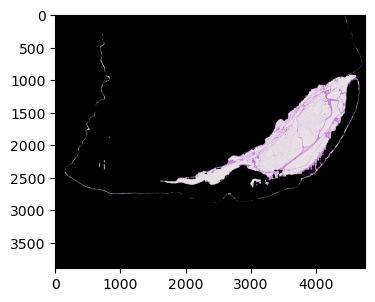

In [51]:
split_mask_ = cv2.bitwise_or(origin, all_mask, mask=object_mask[:,:,0])
split_mask_ = np.where(split_mask_==255, 0, split_mask_)    # 관심 영역만 남도록 함

plt.figure(figsize=(4,4))
plt.imshow(split_mask_)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

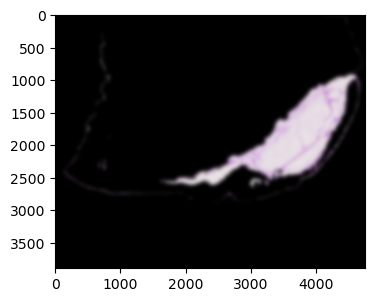

In [53]:
blur_split_mask_ = cv2.GaussianBlur(split_mask_, (201,201), 0)  

plt.figure(figsize=(4,4))
plt.imshow(blur_split_mask_)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

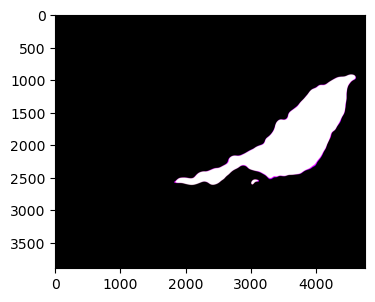

In [55]:
threshold = 100
_, thresholded_split_mask_ = cv2.threshold(blur_split_mask_, threshold, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(4,4))
plt.imshow(thresholded_split_mask_)
plt.show

### 2. Expand

(<AxesSubplot: >, <matplotlib.image.AxesImage at 0x28c036cee20>)

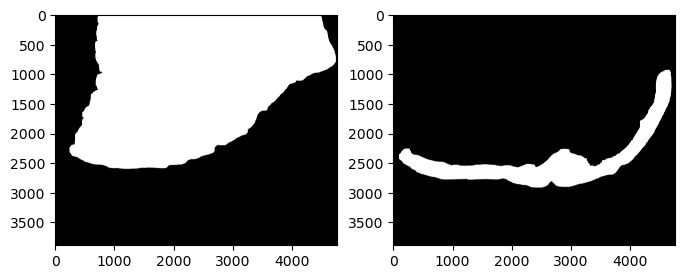

In [57]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
dilated_dermis = cv2.dilate(dermis, kernel, iterations=30)
dilated_epidermis = cv2.dilate(epidermis, kernel, iterations=30)

plt.figure(figsize=(8,4))
plt.subplot(121), plt.imshow(dilated_dermis)
plt.subplot(122), plt.imshow(dilated_epidermis)

### 3. Extract LOI (line of interest)

split mask가 없다면 dermis, epidermis가 겹치는 부분을 기준으로..

(<AxesSubplot: >, <matplotlib.image.AxesImage at 0x28c01d61c10>)

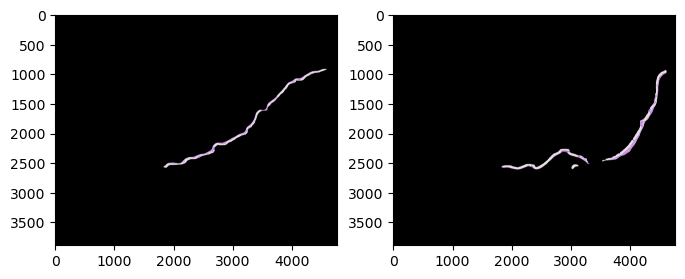

In [58]:
dermis_line = cv2.bitwise_and(origin, dilated_dermis, mask=thresholded_split_mask_[:,:,0])
epidermis_line = cv2.bitwise_and(origin, dilated_epidermis, mask=thresholded_split_mask_[:,:,0])

plt.figure(figsize=(8,4))
plt.subplot(121), plt.imshow(dermis_line)
plt.subplot(122), plt.imshow(epidermis_line)

In [107]:
# c = cv2.bitwise_or(dilated_epidermis, dilated_dermis, mask=split_mask[:,:,0])

# plt.figure(figsize=(5,5))
# plt.imshow(c)
# plt.show

In [59]:
def get_coordinates(contours):
    coordinates = []

    for i in range(len(contours)):
        contour = np.reshape(contours[i], (-1, 2)).tolist()
        coordinates = coordinates + contour

    sorted_coordi = sorted(coordinates, key=lambda x:x[0])  # x좌표 기준 정렬
    return sorted_coordi

In [60]:
dermis_contours, _ = cv2.findContours(dermis_line[:,:,0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
epidermis_contours, _ = cv2.findContours(epidermis_line[:,:,0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [61]:
sorted_dermis_coordi = get_coordinates(dermis_contours)
np.array(sorted_dermis_coordi).shape

(3070, 2)

In [62]:
sorted_epidermis_coordi = get_coordinates(epidermis_contours)
np.array(sorted_epidermis_coordi).shape

(3498, 2)

### 4. Draw and Save Patches

In [63]:
red = (255, 0, 0)
green = (0, 255, 0)
blue = (0, 0, 255)

Num of Patches : 8


<function matplotlib.pyplot.show(close=None, block=None)>

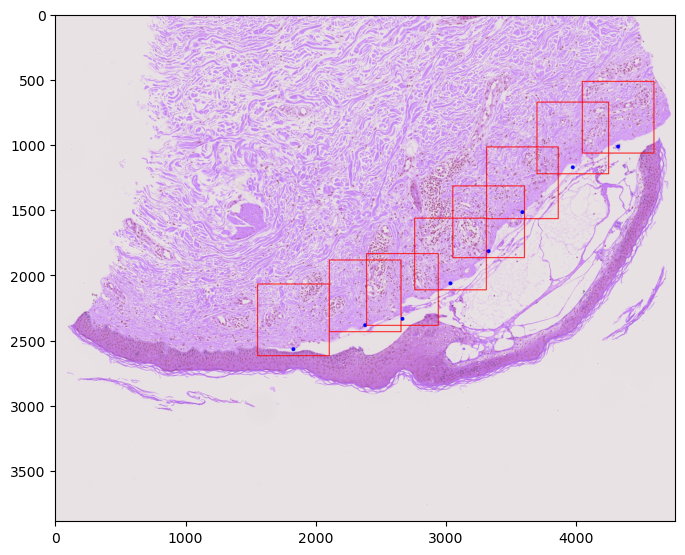

In [64]:
raw_image = origin.copy()

for i in range(0, len(sorted_dermis_coordi), 400):
    x, y = sorted_dermis_coordi[i]
    cv2.line(raw_image, (x,y), (x,y), blue, 30) 
    cv2.rectangle(raw_image, (x-275, y-500), (x+275, y+50), red, 5)

cv2.imwrite(path + 'line/{0}_{1}.png'.format(name[:-4], 'dermis'), raw_image)
print('Num of Patches :', round(len(sorted_dermis_coordi)/400))

plt.figure(figsize=(8,8))
plt.imshow(raw_image)
plt.show

In [66]:
raw_image = origin.copy()
patch_idx = 0

for i in range(0, len(sorted_dermis_coordi), 400):
    patch_idx = patch_idx + 1
    x, y = sorted_dermis_coordi[i]
    patch = raw_image[y-500:y+50, x-275:x+275]
    cv2.imwrite(path + 'patches/{0}_{1}_{2}.png'.format(name[:-4], 'dermis', patch_idx), patch)

print('Num of Patches :', patch_idx)

Num of Patches : 8


Num of Patches : 9


<function matplotlib.pyplot.show(close=None, block=None)>

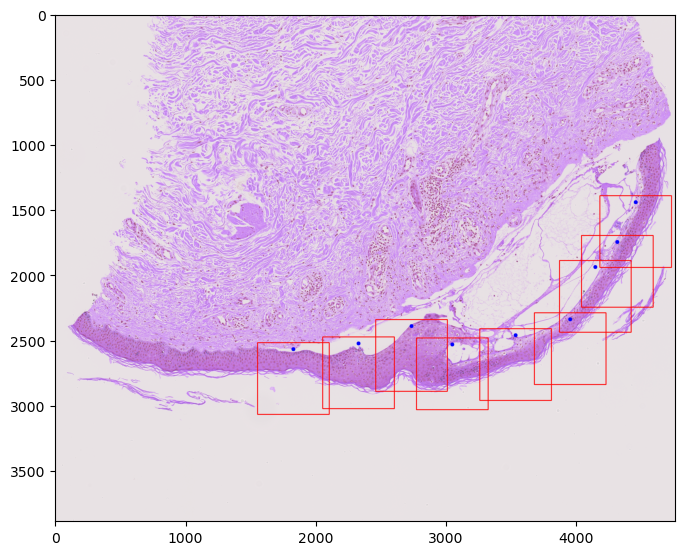

In [65]:
raw_image = origin.copy()

for i in range(0, len(sorted_epidermis_coordi), 400):
    x, y = sorted_epidermis_coordi[i]
    cv2.line(raw_image, (x,y), (x,y), blue, 30) 
    cv2.rectangle(raw_image, (x-275, y+500), (x+275, y-50), red, 5)

cv2.imwrite(path + 'line/{0}_{1}.png'.format(name[:-4], 'epidermis'), raw_image)
print('Num of Patches :', round(len(sorted_epidermis_coordi)/400))

plt.figure(figsize=(8,8))
plt.imshow(raw_image)
plt.show

In [67]:
raw_image = origin.copy()
patch_idx = 0

for i in range(0, len(sorted_epidermis_coordi), 400):
    patch_idx = patch_idx + 1
    x, y = sorted_epidermis_coordi[i]
    patch = raw_image[y-50:y+500, x-275:x+275]
    cv2.imwrite(path + 'patches/{0}_{1}_{2}.png'.format(name[:-4], 'epidermis', patch_idx), patch)

print('Num of Patches :', patch_idx)

Num of Patches : 9
